In [2]:
%load_ext autoreload
%autoreload 2
from geolifeclef.utils import get_spark
from pyspark.sql import functions as F
from geolifeclef.torch.raster.data import RasterDataModel


spark = get_spark(memory="24g")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/anthony/omscs/dsgt-clef/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/anthony/omscs/dsgt-clef/venv/lib/python3.11/site-packages/petastorm/spark/spark_dataset_converter.py:28: FutureWarning: pyarrow.LocalFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  from pyarrow import LocalFileSystem
24/05/17 01:57:55 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [20]:
local_root = "/mnt/data/geolifeclef-2024/data"
dm = RasterDataModel(
    spark,
    f"{local_root}/processed/metadata_clean/v2",
    [
        f"{local_root}/processed/tiles/pa-train/satellite/v3",
    ],
    ["red", "green", "blue", "nir"],
)
dm.setup()

/home/anthony/omscs/dsgt-clef/venv/lib/python3.11/site-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  self._filesystem = pyarrow.localfs
Converting floating-point columns to float32
Converting floating-point columns to float32                                    
The median size 11390479 B (< 50 MB) of the parquet files is too small. Total size: 364465996 B. Increase the median file size by calling df.repartition(n) or df.coalesce(n), which might help improve the performance. Parquet files: file:///mnt/data/tmp/20240517020833-appid-local-1715936265482-2e82a28c-f251-403e-8f8f-8ef44b00dd6f/part-00028-82638f1e-66cf-4c51-b24c-98605e344f4f-c000.parquet, ...


In [21]:
dm.train_data.count(), dm.valid_data.count()

(1334401, 149236)

In [22]:
dm.train_data.printSchema()
dm.train_data.show(1, vertical=True, truncate=80)

root
 |-- surveyId: integer (nullable = true)
 |-- labels_sp: vector (nullable = true)
 |-- dataset: string (nullable = true)
 |-- sample_id: long (nullable = true)
 |-- red: vector (nullable = true)
 |-- green: vector (nullable = true)
 |-- blue: vector (nullable = true)
 |-- nir: vector (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- target: long (nullable = true)

-RECORD 0-------------------------------------------------------------------------------------
 surveyId  | 437405                                                                           
 labels_sp | (11255,[822,1715,2587,5384,5386,6079,6310,6643,6989,7760,7808,7978,9024,10024... 
 dataset   | pa_train                                                                         
 sample_id | 46                                                                               
 red       | [4364792.0,-95616.53125,-13849.54296875,-52997.6953125,-20798.69140625,-33934... 
 green     | [4

In [23]:
row = dm.train_data.sample(0.1).first()
row

Row(surveyId=2632299, labels_sp=SparseVector(11255, {257: 1.0, 413: 1.0, 1176: 1.0, 1771: 1.0, 1903: 1.0, 1912: 1.0, 1946: 1.0, 2064: 1.0, 2356: 1.0, 2386: 1.0, 2753: 1.0, 2765: 1.0, 2946: 1.0, 2973: 1.0, 3125: 1.0, 3356: 1.0, 3572: 1.0, 4114: 1.0, 4229: 1.0, 4326: 1.0, 4886: 1.0, 5982: 1.0, 6011: 1.0, 6054: 1.0, 6808: 1.0, 7199: 1.0, 7408: 1.0, 7748: 1.0, 8391: 1.0, 8921: 1.0, 9307: 1.0, 9572: 1.0, 9776: 1.0, 10073: 1.0, 10127: 1.0, 10419: 1.0, 10815: 1.0, 10947: 1.0}), dataset='pa_train', sample_id=33, red=DenseVector([4888820.0, 1111554.25, -963486.8125, 532052.75, -108801.0, -57422.4844, 38765.9102, -77175.6094, 62870.3828, -237851.3438, 126975.0156, 76601.6094, -202370.2188, 162956.3438, -94771.625, 2452.0137, 14264.2881, 13206.2246, 84183.625, -80866.8125, 24760.1465, 29208.4512, -117630.2578, 104632.4766, 77291.4062, -75432.5469, 30514.0273, 42153.6797, -60431.875, 67156.7734, -16464.4688, 19727.1328, -70339.0391, -22167.668, 2618.6257, -21407.6699, 29303.5938, 25987.3828, 13880

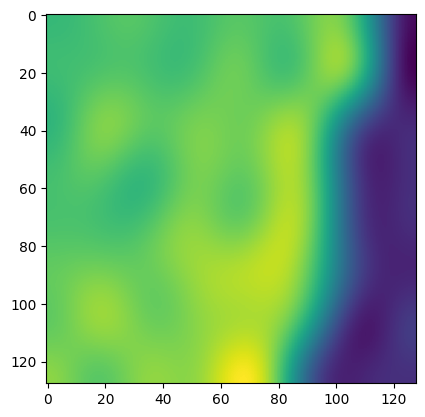

In [24]:
# inverse dct and show image
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import idctn

x = np.zeros((128, 128))
x[:8, :8] = row.blue.toArray().reshape(8, 8)
# inverse dct
x = idctn(x)
plt.imshow(x)
plt.show()

In [21]:
df = spark.read.parquet(
    f"{local_root}/processed/tiles/pa-train/LandCover/LandCover_MODIS_Terra-Aqua_500m/v3"
)
df.printSchema()

root
 |-- LandCover_MODIS_Terra-Aqua_500m_1: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_2: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_3: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_4: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_5: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_6: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_7: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_8: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_9: array (nullable = true)
 |    |-- element: double (contains

In [4]:
local_root = "/mnt/data/geolifeclef-2024/data"
dm = RasterDataModel(
    spark,
    f"{local_root}/processed/metadata_clean/v2",
    [
        f"{local_root}/processed/tiles/pa-train/LandCover/LandCover_MODIS_Terra-Aqua_500m/v3"
    ],
    [f"LandCover_MODIS_Terra-Aqua_500m_{i+1}" for i in range(5)],
)
dm.setup()

/home/anthony/omscs/dsgt-clef/venv/lib/python3.11/site-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  self._filesystem = pyarrow.localfs
Converting floating-point columns to float32
Converting floating-point columns to float32                                    
The median size 12584530 B (< 50 MB) of the parquet files is too small. Total size: 402672549 B. Increase the median file size by calling df.repartition(n) or df.coalesce(n), which might help improve the performance. Parquet files: file:///mnt/data/tmp/20240517020135-appid-local-1715936265482-5bd3387c-3dd4-43ec-b32a-ca0ce1ff4a2f/part-00015-e4e1565f-9fb8-48fd-bed1-be2a96647876-c000.parquet, ...


In [13]:
dm.train_data.printSchema()
row = dm.train_data.sample(0.1).first()
row

root
 |-- surveyId: integer (nullable = true)
 |-- labels_sp: vector (nullable = true)
 |-- dataset: string (nullable = true)
 |-- sample_id: long (nullable = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_1: vector (nullable = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_2: vector (nullable = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_3: vector (nullable = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_4: vector (nullable = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_5: vector (nullable = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_6: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_7: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_8: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_9: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- LandCover_MODIS_Terra-Aqua_500m_10: array (nullable = tru

Row(surveyId=2666798, labels_sp=SparseVector(11255, {146: 1.0, 249: 1.0, 549: 1.0, 628: 1.0, 822: 1.0, 1170: 1.0, 1195: 1.0, 1716: 1.0, 1842: 1.0, 1892: 1.0, 2109: 1.0, 2209: 1.0, 2348: 1.0, 2539: 1.0, 2722: 1.0, 2885: 1.0, 2922: 1.0, 3096: 1.0, 3125: 1.0, 3738: 1.0, 4013: 1.0, 4349: 1.0, 5166: 1.0, 6267: 1.0, 6551: 1.0, 6643: 1.0, 7199: 1.0, 7295: 1.0, 7529: 1.0, 8154: 1.0, 8223: 1.0, 8287: 1.0, 8904: 1.0, 8921: 1.0, 9107: 1.0, 9353: 1.0, 9486: 1.0, 9816: 1.0, 9977: 1.0, 10133: 1.0, 10347: 1.0, 10803: 1.0, 11090: 1.0, 11140: 1.0}), dataset='pa_train', sample_id=19, LandCover_MODIS_Terra-Aqua_500m_1=DenseVector([22302.6406, -10102.3223, -2388.4685, -1183.2319, -892.5623, -582.4262, -846.3392, -717.7003, -21790.1484, 2699.5098, 2528.6455, 1086.3467, 595.467, 1068.2844, 351.0419, 190.5262, 1598.3086, 6457.6074, -159.3851, -1145.8839, -1150.6362, 345.8043, -309.1437, 228.7838, 2118.8789, -2567.1787, -2583.9055, 39.4545, -386.9266, 248.8647, -828.5749, -468.4416, 2468.803, -2526.8767, 2108

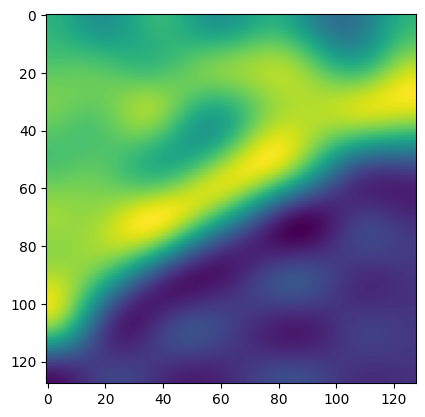

In [19]:
# inverse dct and show image
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import idctn

x = np.zeros((128, 128))
x[:8, :8] = row["LandCover_MODIS_Terra-Aqua_500m_3"].toArray().reshape(8, 8)
# inverse dct
x = idctn(x)
plt.imshow(x)
plt.show()